In [1]:
import numpy as np
import sys,subprocess
import os
import shutil
import matplotlib.pyplot as plt
import scipy.interpolate as sp
import ipyvolume as ipv
sys.path.append('/home/giorgiod/Documents/APDFT/dep')
sys.path.append('/home/giorgiod/Documents/APDFT/src')
from pes_bs_utils import energy

In [2]:
from apdft import calculator
run_sh='/home/giorgiod/Documents/APDFT/prototyping/hessian/PES_BS_COMPARISON_AT_CCSD/run.sh'

In [3]:
proj_path='/home/giorgiod/MRCC_interface/Basis_set_error/'
os.listdir(proj_path)

['def2-QZVPP',
 '631G*',
 'rerun',
 'def2-TZVP',
 'sto3G',
 'sto6G',
 '321G',
 'cc-pVTZ',
 'aug-cc-pVQZ (copy 1)',
 'rerun2',
 'makefold.py',
 'savings',
 'aug-cc-pVQZ']

In [4]:
basisSets=['sto3G', 'sto6G', '321G','631G*','def2-TZVP','def2-QZVPP','cc-pVTZ','aug-cc-pVQZ']
molecules=['HAl','HeMg','LiNa','BeNe','BF','CO','NN']
Nums={
    "NN":[7,7],
    "CO":[6,8],
    "BF":[5,9],
    "BeNe":[4,10],
    "LiNa":[3,11],
    "HeMg":[2,12],
    "HAl":[1,13]
}
points= np.linspace(1.30,3.20,20)

In [5]:
def dirName_bse(basis_set,molecule,target,point):
    return proj_path+basis_set+'/{}/{}_to_{}_distance_{}/'.format(molecule,molecule,target,str(point)[0:3])
print (os.path.isdir(dirName_bse(basisSets[3],molecules[2],molecules[1],points[3])))
print (dirName_bse(basisSets[3],molecules[2],molecules[1],points[3]))

True
/home/giorgiod/MRCC_interface/Basis_set_error/631G*/LiNa/LiNa_to_HeMg_distance_1.6/


In [6]:
def parse_energy_cc(log_file):
    """Parse the couple cluster energy from an MRCC output file"""
    try:
        with open(log_file,'r') as logf:
            while True:
                line=logf.readline()
                if "Final results:" in line:
                    good_line=logf.readline()
                    if "Total CCSD energy" in good_line:
                        for x in good_line.split(' '):
                            try:
                                float(x)
                                return (float(x))
                            except:
                                pass    
    except:
        print('couldn\'t parse energy return 0 for: '+log_file)
        return 0
    
def energy_bse(bs,mol,targ,pt):
    return parse_energy_cc(dirName_bse(bs,mol,targ,pt)+'run.log')

In [7]:
os.system('ls')

0

In [8]:
def parse_energy_hf(log_file):
    """Parse the hartree Fock energy from an MRCC output file"""
    try:
        with open(log_file,'r') as logf:
            while True:
                line=logf.readline()
                if "FINAL HARTREE-FOCK ENERGY:" in line:
                    good_line=line
                    for x in good_line.split(' '):
                        try:
                            float(x)
                            return (float(x))
                        except:
                            pass    
    except:
        print('couldn\'t parse energy return 0 for: '+log_file)
        return 0
    
def energy_hf_bse(bs,mol,targ,pt):
    return parse_energy_hf(dirName_bse(bs,mol,targ,pt)+'run.log')

In [9]:
def scfig_MINP(minp_file):
    if (minp_file.split('/')[-1]!='MINP'):
        print ('not a MINP file '+minp_file)
        return
    try:
        with open(minp_file,'r') as minp:
            old_text=minp.read()
        if not ('scfiguess=mo' in old_text ):
            new_text='scfiguess=mo \n'+old_text
            with open(minp_file,'w') as minp:
                minp.write(new_text)
        else:
            print ('file {} already modified, no changes made'.format(minp_file))
    except:
        print ('unable to read or modify MINP at:'+minp_file)
    return


In [10]:
def ccalc_MINP(minp_file,calc):
    if calc not in ('ccsd','uhf'):
        print('not a valid calc, '+calc)
    if (minp_file.split('/')[-1]!='MINP'):
        print ('not a MINP file '+minp_file)
        return
    try:
        with open(minp_file,'r') as minp:
            old_text=minp.read()
        if (calc=='uhf'): 
            if  ('calc=CCSD' in old_text ):
                old_text=old_text.replace('calc=CCSD','calc=UHF')
                new_text=old_text.replace('mem=39GB','mem=3GB')
                with open(minp_file,'w') as minp:
                    minp.write(new_text)
            else:
                print ('file {} is not a CCSD calculus'.format(minp_file))
        if (calc=='ccsd'):    
            if  ('calc=UHF' in old_text ):
                old_text=old_text.replace('calc=UHF','calc=CCSD')
                new_text=old_text.replace('mem=3GB','mem=39GB')
                with open(minp_file,'w') as minp:
                    minp.write(new_text)
            else:
                print ('file {} is not a UHF calculus'.format(minp_file))       
                
    except:
        print ('unable to read or modify MINP at:'+minp_file)
    return    


In [11]:
#ccalc_MINP('/home/giorgiod/Desktop/hessian/PES_BS_COMPARISON_AT_CCSD/MINP','uhf')
#os.path.abspath('.')

In [12]:
def rerun(bs,ref,target,goodpt,badpts):
    calc_list=[goodpt,*badpts]
    for i in range(len(calc_list)-1):
        os.chdir(dirName_bse(bs,ref,target,calc_list[i]))
        print(not 'MOCOEF' in os.listdir('.'))
        if (not 'MOCOEF' in os.listdir('.')):
            shutil.copy(run_sh,'.')
            print ("running MRCC in {}".format(dirName_bse(bs,ref,target,calc_list[i])))
            subprocess.call(["bash", "run.sh"])
            os.system('rm fort*')    
        shutil.copy(dirName_bse(bs,ref,target,calc_list[i])+'MOCOEF',dirName_bse(bs,ref,target,calc_list[i+1])+'.')
        scfig_MINP(dirName_bse(bs,ref,target,calc_list[i+1])+'MINP')  # adding scfiguess=mo to MINP file
        os.chdir(dirName_bse(bs,ref,target,calc_list[i+1]))
        shutil.copy(run_sh,'.')
        print ("running MRCC in {}".format(dirName_bse(bs,ref,target,calc_list[i+1])))
        subprocess.call(["bash", "run.sh"])
        os.system('rm fort*')

In [13]:
def rerun_hf(bs,ref,target,goodpt,badpts):
    
    shutil.copytree(dirName_bse(bs,ref,target,goodpt),\
        proj_path+'savings/'+bs+'/{}/{}_to_{}_distance_{}/'.format(ref,ref,target,str(goodpt)[0:3]))
    calc_list=[goodpt,*badpts]
    
    for i in range(len(calc_list)-1):
        os.chdir(dirName_bse(bs,ref,target,calc_list[i]))
        print(not 'MOCOEF' in os.listdir('.'))
        if not 'MOCOEF' in os.listdir('.'):
            ccalc_MINP(dirName_bse(bs,ref,target,calc_list[i])+'MINP','uhf')        #got to uhf
            shutil.copy(run_sh,'.')
            print ("running MRCC in {}".format(dirName_bse(bs,ref,target,calc_list[i])))
            os.system('bash run.sh')
            os.system('rm fort*')    
        shutil.copy(dirName_bse(bs,ref,target,calc_list[i])+'MOCOEF',dirName_bse(bs,ref,target,calc_list[i+1])+'.')
        scfig_MINP(dirName_bse(bs,ref,target,calc_list[i+1])+'MINP')  # adding scfiguess=mo to MINP file
        os.chdir(dirName_bse(bs,ref,target,calc_list[i+1]))
        shutil.copy(run_sh,'.')
        ccalc_MINP(dirName_bse(bs,ref,target,calc_list[i+1])+'MINP','uhf')        #got to uhf
        print ("running MRCC in {}".format(dirName_bse(bs,ref,target,calc_list[i+1])))
        os.system('bash run.sh')
        os.system('rm fort*')
    
     #copy back from savings
    #shutil.copytree(proj_path+'savings/'+bs+'/{}/{}_to_{}_distance_{}/'.format(ref,ref,target,str(goodpt)[0:3])\
     #       ,dirName_bse(bs,ref,target,goodpt))
    
    # copy the folders to /rerun/
    """for calc_uhf in badpts:
        shutil.copytree(dirName_bse(bs,ref,target,calc_uhf),\
        proj_path+'rerun/'+bs+'/{}/{}_to_{}_distance_{}/'.format(ref,ref,target,str(calc_uhf)[0:3]))
        ccalc_MINP(proj_path+'rerun/'+bs+'/{}/{}_to_{}_distance_{}/'.format(ref,ref,target,str(calc_uhf)[0:3])+'MINP','ccsd')
        """

In [14]:
#rerun_hf('aug-cc-pVQZ','BeNe','HAl',2.4,[2.3,2.2,2.1,2.0,1.9,1.8,1.7,1.6,1.5,1.4,1.3])
#rerun_hf('aug-cc-pVQZ','BF','HAl',2.2,[2.1,2.0,1.9,1.8,1.7,1.6,1.5,1.4,1.3])
#rerun_hf('aug-cc-pVQZ','LiNa','HAl',2.8,[2.7,2.6,2.5,2.4,2.3,2.2,2.1])

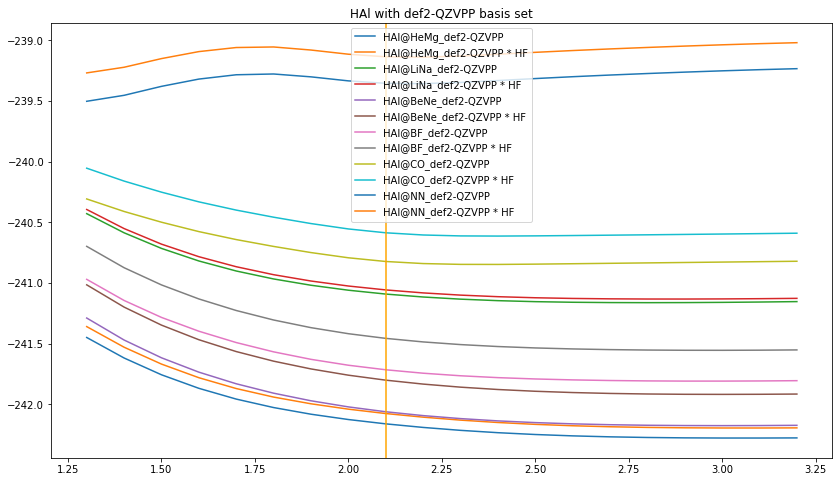

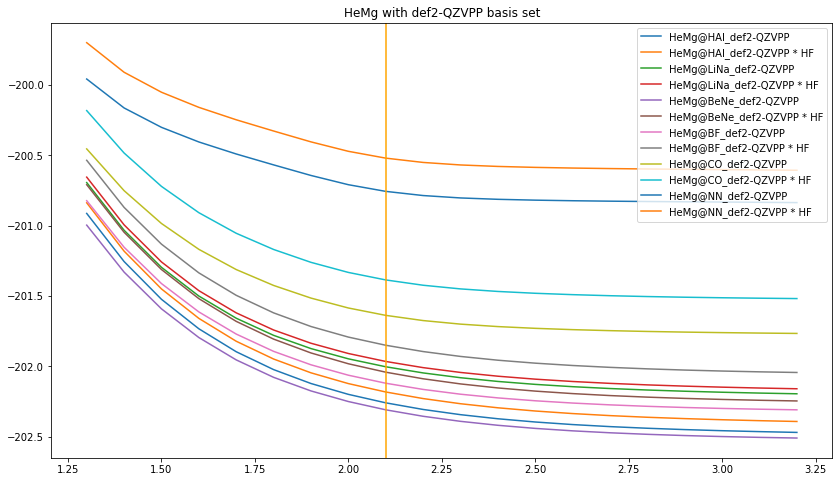

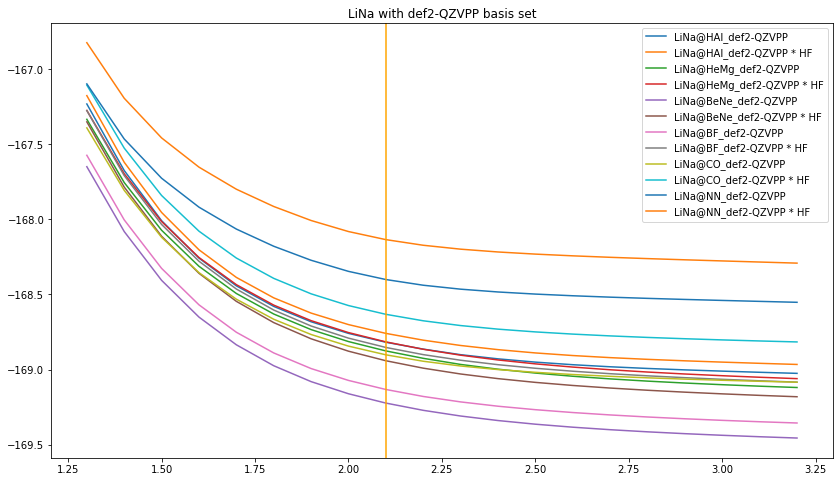

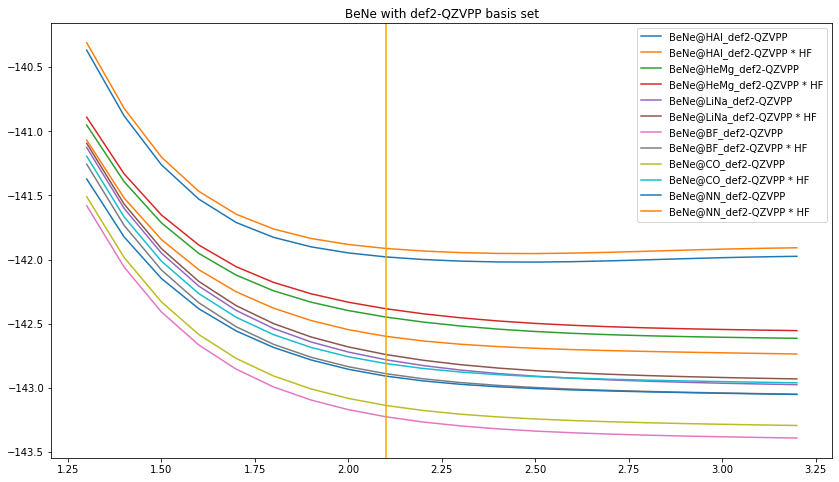

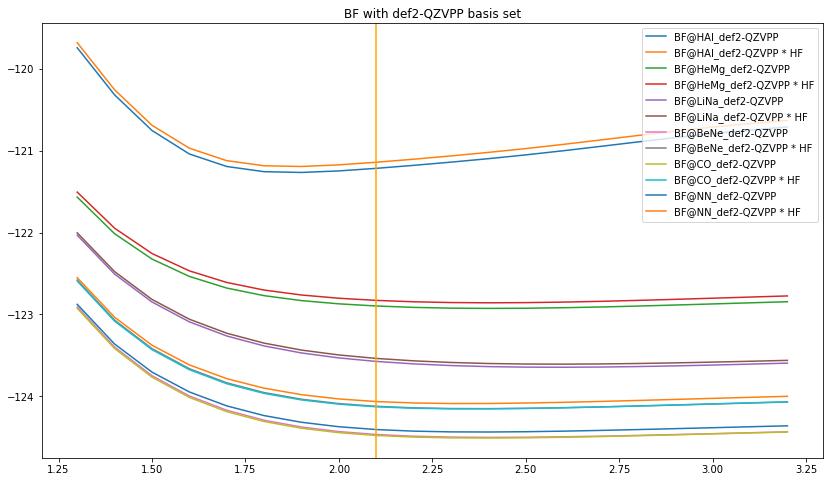

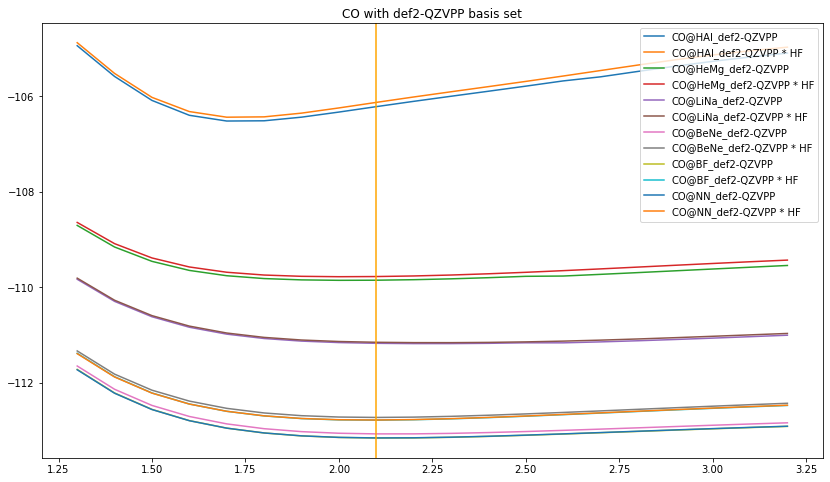

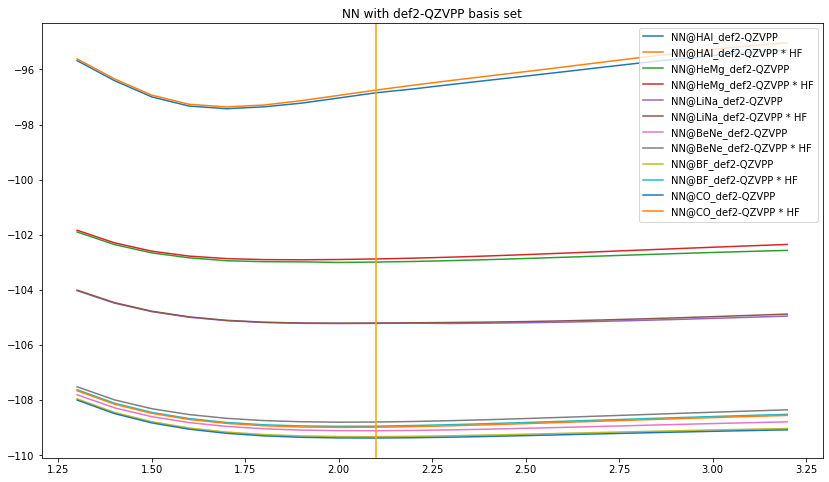

In [15]:

bs='def2-QZVPP'
for target in molecules:
    fig=plt.figure(figsize=(14,8))
    for ref in molecules:
        if (ref!=target):
            plt.plot(points,[energy_bse(bs,ref,target,pt) for pt in points],label='{}@{}_{}'.format(target,ref,bs))
            plt.plot(points,[energy_hf_bse(bs,ref,target,pt) for pt in points],label='{}@{}_{} * HF'.format(target,ref,bs))
    plt.title('{} with {} basis set'.format(target,bs))
    plt.legend()
    
    plt.axvline(2.1,color='orange')
    plt.show()
    #plt.ylim(-204,-199)

<Figure size 1008x576 with 0 Axes>

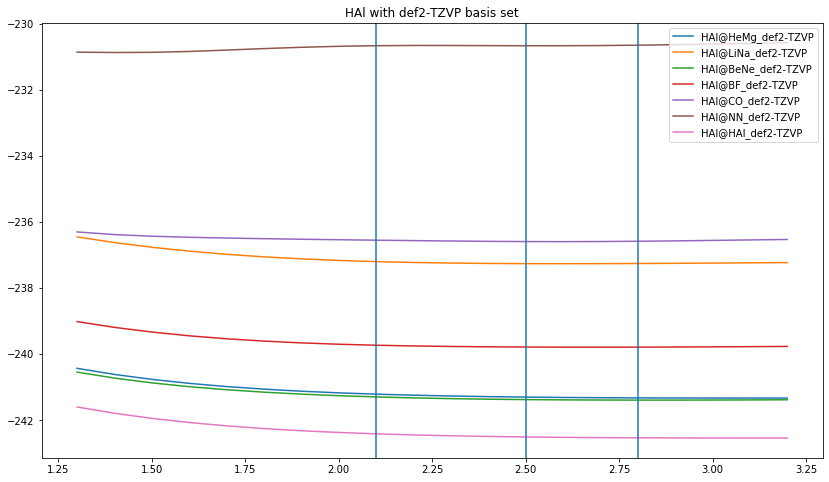

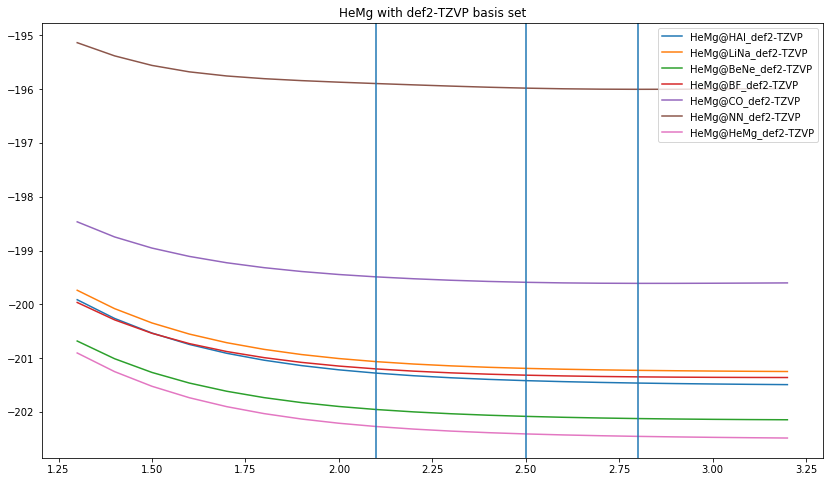

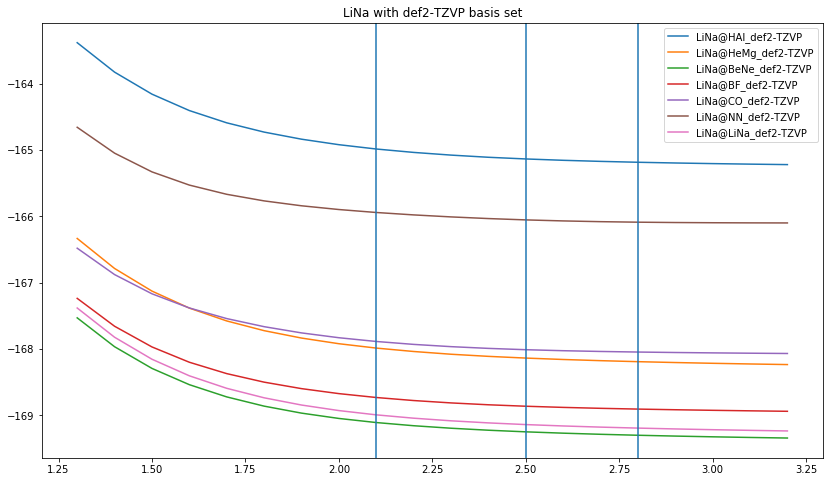

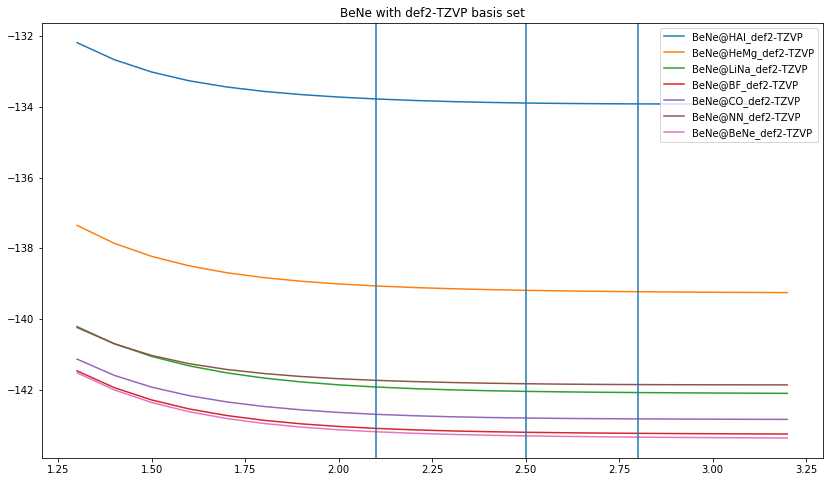

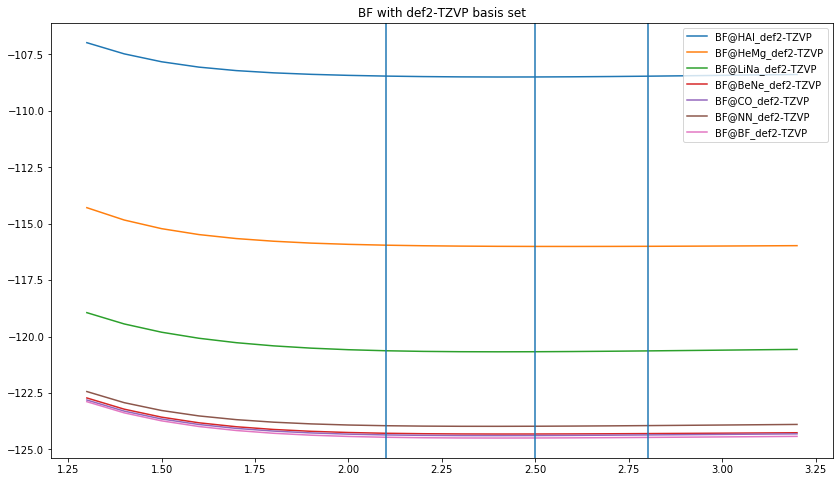

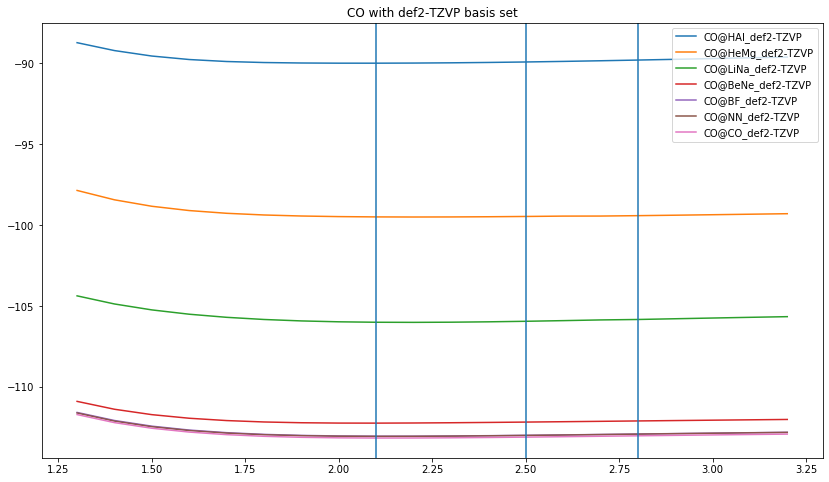

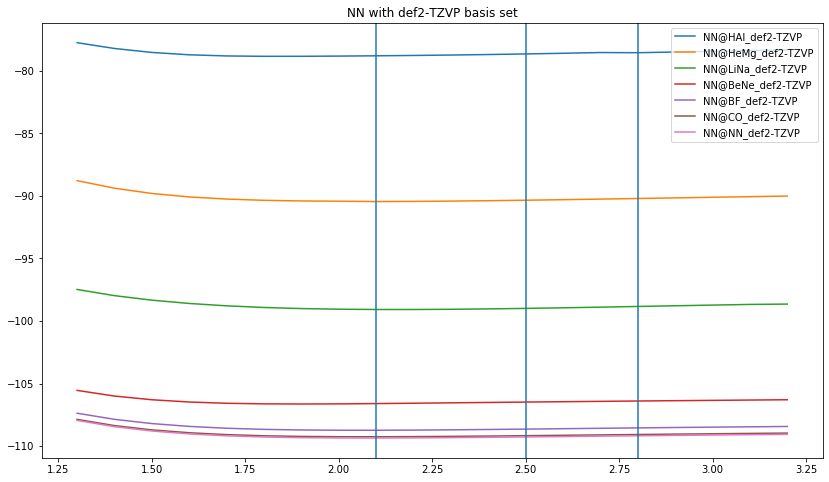

In [30]:
#target a molecule with bs belonging to other reference molecule: 1 graph for each target-basis  
fig=plt.figure(figsize=(14,8))
#for bs in ['sto3G', 'sto6G', '321G','631G*','def2-TZVP','def2-QZVPP']:#,'cc-pVTZ']:
bs='def2-TZVP'
for target in molecules:
#    target='HAl'
    fig=plt.figure(figsize=(14,8))
    for ref in molecules:
        if ref!=target:
            plt.plot(points,[energy_bse(bs,ref,target,pt) for pt in points],label='{}@{}_{}'.format(target,ref,bs))
            #plt.plot(points,[energy_hf_bse(bs,ref,target,pt) for pt in points],label='{}@{}_{} *HF'.format(target,ref,bs))
    plt.plot(points,[energy(bs,target,pt) for pt in points],label='{}@{}_{}'.format(target,target,bs))
    plt.title('{} with {} basis set'.format(target,bs))
    plt.legend()
    plt.axvline(2.1)
    plt.axvline(2.8)
    plt.axvline(2.5)

    plt.show()


In [17]:
import pandas as pd
import numpy as np
import bokeh

In [ ]:
#now populate a pd dataframe 
# energy_bse(bs,ref,target,pt)
# e_at_ref_bs, ref, target, distance

In [35]:
"""for bs in ['631G*']:
    q=[]
    for ref in molecules:
        for target in molecules:
            if target != ref:
                for distance in points:
                    q.append({"ref":ref,"target":target,"distance":distance,"e_at_ref_bs":energy_bse(bs,ref,target,distance)}) 
    exec("bse_%s=pd.DataFrame(q)"%(bs.replace('*','')))
    """

In [43]:
bse_sto3G.to_pickle('./bse_sto3G')
bse_sto6G.to_pickle('./bse_sto6G')
bse_321G.to_pickle('./bse_321G')
bse_631G.to_pickle('./bse_631G')
bse_def2_TZVP.to_pickle('./bse_def2_tzvp')
bse_def2_QZVPP.to_pickle('./bse_def2_qzvpp')
bse_cc_pVTZ.to_pickle('./bse_ccpvtz')
bse_aug_cc_pVQZ.to_pickle('./bse_aug')